# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Incidents

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=True, processed=True, enhanced=True)

Loading dataset: 100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


In [5]:
data = data_loader.enhanced_incidents_df

# Correlation

Year 2016 - Pearson Correlation Coefficient: -0.223, P-value: 1.61e-05
Year 2017 - Pearson Correlation Coefficient: -0.400, P-value: 1.94e-15
Year 2018 - Pearson Correlation Coefficient: -0.384, P-value: 2.73e-14


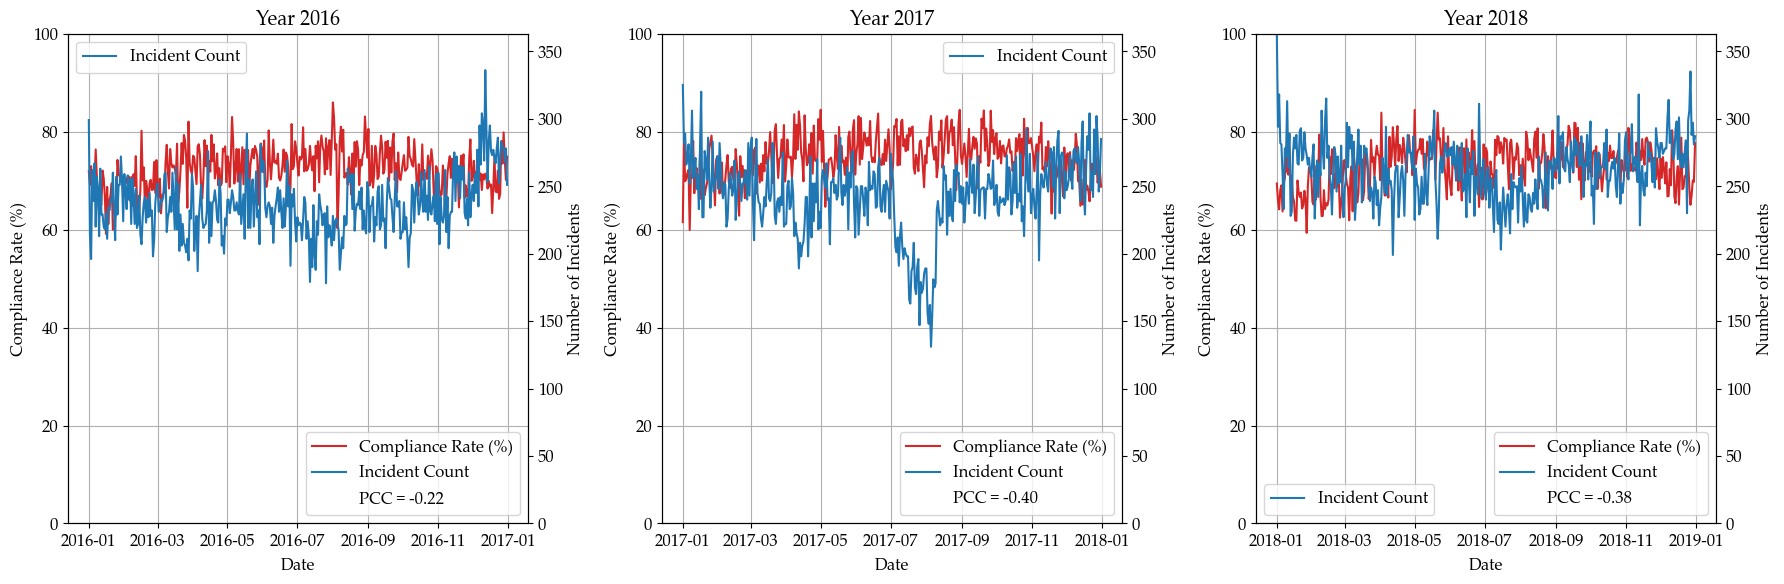

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

data['time_call_received'] = pd.to_datetime(data['time_call_received'])
data['time_ambulance_arrived_at_scene'] = pd.to_datetime(data['time_ambulance_arrived_at_scene'])
data['response_time_minutes'] = (data['time_ambulance_arrived_at_scene'] - data['time_call_received']).dt.total_seconds() / 60

# Define compliance conditions
conditions = [
    (data['triage_impression_during_call'] == 'A') & (data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'A') & (~data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'H') & (data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'H') & (~data['urban_settlement_ssb']),
]
choices = [12, 25, 30, 40]
data['compliance_limit'] = np.select(conditions, choices, default=40)
data['is_compliant'] = data['response_time_minutes'] <= data['compliance_limit']

# Group data by date
daily_stats = data.groupby(data['time_call_received'].dt.date).agg({
    'is_compliant': 'mean',
    'triage_impression_during_call': 'count'
})
daily_stats['compliance_rate'] = daily_stats['is_compliant'] * 100
daily_stats.index = pd.to_datetime(daily_stats.index)

# Filter data by year for plotting
years = [2016, 2017, 2018]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=False, sharex=False)

# Get maximum incident count to set the limits of the right y-axis
max_incident_count = daily_stats['triage_impression_during_call'].max()

for ax, year in zip(axes, years):
    yearly_data = daily_stats[daily_stats.index.year == year]
    corr_coeff, p_value = pearsonr(yearly_data['triage_impression_during_call'], yearly_data['compliance_rate'])
    print(f"Year {year} - Pearson Correlation Coefficient: {corr_coeff:.3f}, P-value: {p_value:.3g}")

    # Plot compliance rate
    line1 = sns.lineplot(ax=ax, x=yearly_data.index, y=yearly_data['compliance_rate'], color='tab:red', label='Compliance Rate (%)')

    # Plot number of incidents on secondary y-axis
    ax2 = ax.twinx()
    line2 = sns.lineplot(ax=ax2, x=yearly_data.index, y=yearly_data['triage_impression_during_call'], color='tab:blue', label='Incident Count')

    # Set the limits of the right y-axis to match the maximum incident count
    ax2.set_ylim(0, max_incident_count)

    # Customize subplot title and axis labels
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Compliance Rate (%)')
    ax.set_ylim(0, 100)
    ax2.set_ylabel('Number of Incidents')
    ax.grid(True)

    # Combine legends from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2
    legend_text = f'PCC = {corr_coeff:.2f}'
    handles.append(plt.Line2D([], [], color='white'))  # Add an empty line for spacing
    labels.append(legend_text)
    ax.legend(handles, labels, loc='lower right')

plt.tight_layout()
plt.savefig('./plots/compliance_incident_correlation.png', dpi=300, bbox_inches='tight')

plt.show()


Year 2016 - Pearson Correlation Coefficient: 0.387, P-value: 1.56e-14
Year 2017 - Pearson Correlation Coefficient: 0.255, P-value: 8.35e-07
Year 2018 - Pearson Correlation Coefficient: 0.295, P-value: 9.13e-09


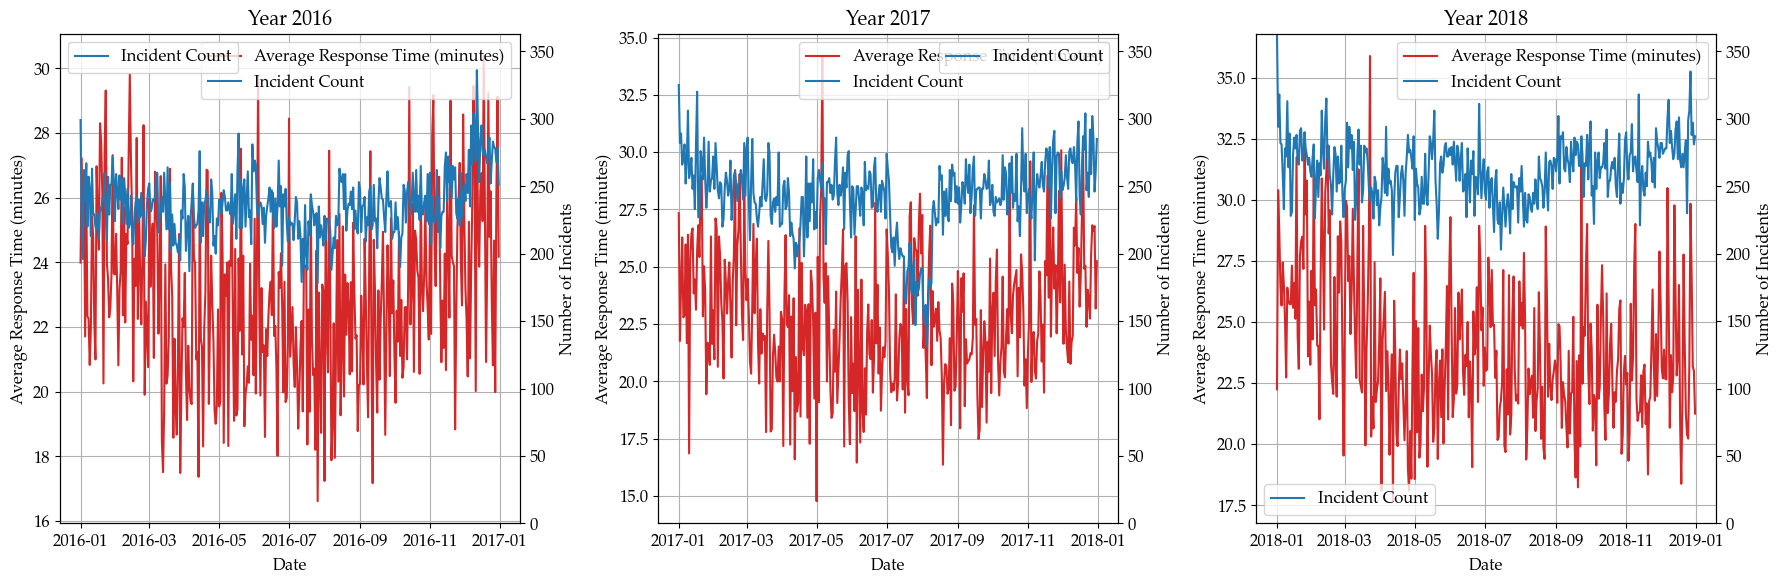

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# Assuming data is already loaded and structured correctly
data['time_call_received'] = pd.to_datetime(data['time_call_received'])
data['time_ambulance_arrived_at_scene'] = pd.to_datetime(data['time_ambulance_arrived_at_scene'])
data['response_time_minutes'] = (data['time_ambulance_arrived_at_scene'] - data['time_call_received']).dt.total_seconds() / 60

# Group data by date and aggregate
daily_stats = data.groupby(data['time_call_received'].dt.date).agg({
    'response_time_minutes': 'mean',  # Average response time per day
    'triage_impression_during_call': 'count'  # Incident count per day
})
daily_stats.index = pd.to_datetime(daily_stats.index)

# Filter data by year for plotting
years = [2016, 2017, 2018]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=False, sharex=False)

# Get maximum incident count to set the limits of the right y-axis
max_incident_count = daily_stats['triage_impression_during_call'].max()

for ax, year in zip(axes, years):
    yearly_data = daily_stats[daily_stats.index.year == year]
    corr_coeff, p_value = pearsonr(yearly_data['triage_impression_during_call'], yearly_data['response_time_minutes'])
    print(f"Year {year} - Pearson Correlation Coefficient: {corr_coeff:.3f}, P-value: {p_value:.3g}")

    # Plot average response time
    sns.lineplot(ax=ax, x=yearly_data.index, y=yearly_data['response_time_minutes'], color='tab:red', label='Average Response Time (minutes)')

    # Plot number of incidents on secondary y-axis
    ax2 = ax.twinx()
    sns.lineplot(ax=ax2, x=yearly_data.index, y=yearly_data['triage_impression_during_call'], color='tab:blue', label='Incident Count')

    # Set subplot titles and axis labels
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Response Time (minutes)')
    ax2.set_ylabel('Number of Incidents')
    ax2.set_ylim(0, max_incident_count)
    ax.grid(True)

    # Combine legends from both axes
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles + handles2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.savefig('./plots/response_time_incident_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# Create a dictionary with sample traffic factors for each hour and day
traffic_data = {
    'hour': [f"{hour:02}:00" for hour in range(24)],
    'Mon': [1.2, 1.2, 1.2, 1.2, 1.1, 1.0, 1.2, 1.5, 1.8, 1.4, 1.3, 1.3, 1.4, 1.4, 1.4, 1.7, 1.9, 1.6, 1.4, 1.4, 1.3, 1.3, 1.3, 1.3],
    'Tues': [1.3, 1.3, 1.2, 1.2, 1.1, 1.0, 1.2, 1.6, 1.8, 1.5, 1.3, 1.4, 1.4, 1.4, 1.5, 1.8, 2.0, 1.6, 1.4, 1.4, 1.3, 1.3, 1.3, 1.3],
    'Wed': [1.3, 1.3, 1.3, 1.2, 1.1, 1.0, 1.2, 1.5, 1.8, 1.4, 1.3, 1.4, 1.4, 1.4, 1.5, 1.8, 2.0, 1.6, 1.5, 1.4, 1.3, 1.3, 1.4, 1.3],
    'Thurs': [1.3, 1.3, 1.3, 1.3, 1.1, 1.0, 1.2, 1.5, 1.7, 1.4, 1.3, 1.4, 1.4, 1.4, 1.5, 1.9, 2.0, 1.6, 1.4, 1.4, 1.3, 1.3, 1.4, 1.3],
    'Fri': [1.3, 1.3, 1.4, 1.3, 1.1, 1.0, 1.1, 1.3, 1.5, 1.3, 1.3, 1.3, 1.4, 1.5, 1.6, 1.8, 1.7, 1.5, 1.4, 1.3, 1.3, 1.3, 1.3, 1.4],
    'Sat': [1.27, 1.27, 1.36, 1.36, 1.18, 1.09, 1.0, 1.0, 1.0, 1.09, 1.09, 1.18, 1.18, 1.27, 1.27, 1.27, 1.27, 1.18, 1.18, 1.18, 1.18, 1.18, 1.18, 1.27],
    'Sun': [1.27, 1.27, 1.36, 1.36, 1.18, 1.09, 1.09, 1.0, 1.0, 1.0, 1.09, 1.09, 1.18, 1.18, 1.18, 1.18, 1.18, 1.18, 1.18, 1.18, 1.09, 1.09, 1.09, 1.09]
}

traffic_factor_df = pd.DataFrame(traffic_data)

In [9]:
# Assuming 'data' is your DataFrame from the incident records
data['day_of_week'] = data['time_call_received'].dt.day_name()  # Get the day name
data['hour'] = data['time_call_received'].dt.strftime('%H:00')  # Format hour as string like '01:00'

In [10]:
# Let's first make sure we print the column names to see if 'Hour' exists
print(traffic_factor_df.columns)

# Assuming the columns are set correctly and include 'Hour'
traffic_factor_long = pd.melt(traffic_factor_df, id_vars=['Hour'], var_name='day_of_week', value_name='traffic_factor')

# Map day names to full names
traffic_factor_long['day_of_week'] = traffic_factor_long['day_of_week'].map({
    'Mon': 'Monday', 'Tues': 'Tuesday', 'Wed': 'Wednesday', 'Thurs': 'Thursday', 
    'Fri': 'Friday', 'Sat': 'Saturday', 'Sun': 'Sunday'
})

# Ensure the rename function is applied before trying to merge
traffic_factor_long.rename(columns={'Hour': 'hour'}, inplace=True)

# Merge the data
merged_data = pd.merge(data, traffic_factor_long, how='left', on=['day_of_week', 'hour'])


Index(['hour', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], dtype='object')


KeyError: "The following 'id_vars' are not present in the DataFrame: ['Hour']"

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Convert timestamps to date and hour for merging
data['date'] = data['time_call_received'].dt.date
data['hour'] = data['time_call_received'].dt.hour

# Compute compliance as you have in your script
data['response_time_minutes'] = (data['time_ambulance_arrived_at_scene'] - data['time_call_received']).dt.total_seconds() / 60
conditions = [
    (data['triage_impression_during_call'] == 'A') & (data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'A') & (~data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'H') & (data['urban_settlement_ssb']),
    (data['triage_impression_during_call'] == 'H') & (~data['urban_settlement_ssb']),
]
choices = [12, 25, 30, 40]
data['compliance_limit'] = np.select(conditions, choices, default=40)
data['is_compliant'] = data['response_time_minutes'] <= data['compliance_limit']

# Calculate daily compliance rates
daily_compliance = data.groupby('date').agg({
    'is_compliant': 'mean'
})
daily_compliance['compliance_rate'] = daily_compliance['is_compliant'] * 100

# Assuming traffic_data is structured properly with 'date', 'hour', and 'traffic_factor'
# Align traffic data with compliance data
merged_data = daily_compliance.merge(traffic_data, left_index=True, right_on='date', how='left')

# Calculate average traffic factor per day if needed
daily_traffic = traffic_data.groupby('date').agg({
    'traffic_factor': 'mean'
})

# Merge average traffic factor with compliance rates
final_data = daily_compliance.merge(daily_traffic, left_index=True, right_index=True, how='left')

# Calculate correlation
corr_coeff, _ = pearsonr(final_data['compliance_rate'], final_data['traffic_factor'])
print(f'The Pearson correlation coefficient between daily compliance rate and average daily traffic factor is {corr_coeff:.2f}')



NameError: name 'traffic_data' is not defined